In [107]:
import os, sys
os.chdir('/home/koritskiy/rqc/hamiltonian_learning')

from random import seed

from modules.main import *
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
np.set_printoptions(suppress=True)

In [108]:
def double_plot(Y1, Y2, Y1_name=None, Y2_name=None):

    X = range(len(Y1))
    fig, ax1 = plt.subplots()

    color = 'tab:red'
    ax1.set_xlabel('iterations')
    if Y1_name:
        ax1.set_ylabel(Y1_name, color=color)
    else:
        ax1.set_ylabel("Y1", color=color)
    ax1.scatter(X, Y1, color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    if Y1_name:
        ax2.set_ylabel(Y2_name, color=color)
    else:
        ax2.set_ylabel("Y2", color=color)  # we've already handled the x-label with ax1
    ax2.scatter(X, Y2, color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()
    plt.show()

In [158]:
# Some initial parameters
np.random.seed(44)
seed(44)

eps = 10 ** -1

n_spins = 2
beta = 100
cycles = 500

lr = 0.1
gradient_iterations = 1

# Create initial random basis angles
theta = np.random.rand(n_spins) * np.pi
phi = np.random.rand(n_spins) * 2 * np.pi
# theta = np.array([0.])
# phi = np.array([0.])

# angles = np.array([theta, phi]).T
angles = np.array([[-np.pi/4, 0], [-np.pi/4, 0]])

# Create target hamiltonian
# z_t = np.random.rand(n_spins) * 2 - 1
# zz_t = np.random.rand(n_spins - 1) * 2 - 1

# z_g = np.random.rand(n_spins) * 2 - 1
# zz_g = np.random.rand(n_spins - 1) * 2 - 1
# xx_t = [-0.3, 0.5]
# yy_t = [-0.2, 0.2]
z_t = [-1, -1]
x_t = [0, 0]

# xx_g = [0.4, -0.1]
# yy_g = [0.8, 0.1]
z_g = [0, 0]
x_g = [-1, -1]


hamiltonian_t = Hamiltonian(n_spins, beta, z=z_t, x=x_t)
hamiltonian_t.set_density_mat()
hamiltonian_g = Hamiltonian(n_spins, beta, z=z_g, x=x_g)
hamiltonian_g.set_density_mat()
print(hamiltonian_t.density_mat)
print(hamiltonian_g.density_mat)

[[1.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j]]
[[0.25+0.j 0.25+0.j 0.25+0.j 0.25+0.j]
 [0.25+0.j 0.25+0.j 0.25+0.j 0.25+0.j]
 [0.25+0.j 0.25+0.j 0.25+0.j 0.25+0.j]
 [0.25+0.j 0.25+0.j 0.25+0.j 0.25+0.j]]


In [159]:
X = np.linspace(1, cycles, cycles)
Theta1 = np.zeros(cycles)
Theta2 = np.zeros(cycles)
Phi1 = np.zeros(cycles)
Phi2 = np.zeros(cycles)
Distance = np.zeros(cycles)
for i in tqdm(range(cycles)):
    grad = Gradient(hamiltonian_t, hamiltonian_g, angles)
    angles = grad.gradient_descent(lr=lr, num_iterations=gradient_iterations)
    singles_t, correlators_t = hamiltonian_t.measure(angles)
    singles_g, correlators_g = hamiltonian_g.measure(angles)

#     print(f"singles_t {singles_t}")
#     print(f"singles_g {singles_g}")
    distance = distance_by_measurements(singles_g, singles_t, correlators_g, correlators_t)
#     print(f"cycle n = {n}")
#     print(f"distance {distance}")
#     print(f"theta {angles[0, 0] % np.pi}")
#     print(f"phi {angles[0, 1] % (2 * np.pi)}")
#     print(' ')

    Theta1[i] = angles[0, 0] / np.pi
    Theta2[i] = angles[1, 0] / np.pi
    Phi1[i] = angles[0, 1] /np.pi
    Phi2[i] = angles[1, 1] /np.pi
    Distance[i] = distance

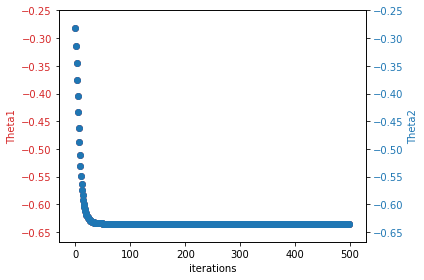

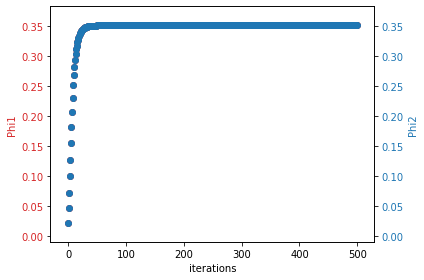

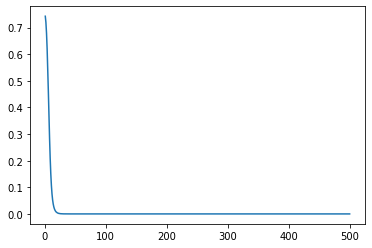

In [160]:
double_plot(Theta1, Theta2, "Theta1", "Theta2")
double_plot(Phi1, Phi2, "Phi1", "Phi2")
plt.plot(X, Distance)

In [161]:
# angles = np.array([[-np.pi/4, 0], [np.pi/4, 0]])
singles_t, correlators_t = hamiltonian_t.measure(angles)
singles_g, correlators_g = hamiltonian_g.measure(angles)
print(distance_by_measurements(singles_g, singles_t, correlators_g, correlators_t))
print(singles_t, singles_g)
print(correlators_t, correlators_g)

1.0665691033080444e-16
[[0.29478779 0.70521216]
 [0.29478779 0.70521216]] [[0.2947878  0.70521217]
 [0.2947878  0.70521217]]
[[0.08689984 0.20788795 0.20788795 0.49732421]] [[0.08689985 0.20788795 0.20788795 0.49732422]]


In [24]:
singles_t

array([[0.85355339, 0.14644661]])

In [25]:
singles_g

array([[0.14644661, 0.85355339]])

In [162]:
print(Theta1[-1])
print(Theta2[-1])
print(Phi1[-1])
print(Phi2[-1])

-0.6346194288953452
-0.6346194288953452
0.3513959131954138
0.3513959131954138


In [ ]:
test_angles = np.array([[np.pi/2, 0], [np.pi/2, 0])